----------------------------------

# **Time Series with RNN and LSTM**

----------------------------------

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_series, trend, seasonal_pattern
from utils import seasonality, noise, generate_synthetic_timeseries
from utils import windowed_dataset, model_forecast

## **1) Time Series with Recurrent Neural Network (RNN)**
------------------

### Agenda

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

#### **1.1) Generating the Series**

In [3]:
# Getting the time series
series, time = generate_synthetic_timeseries()

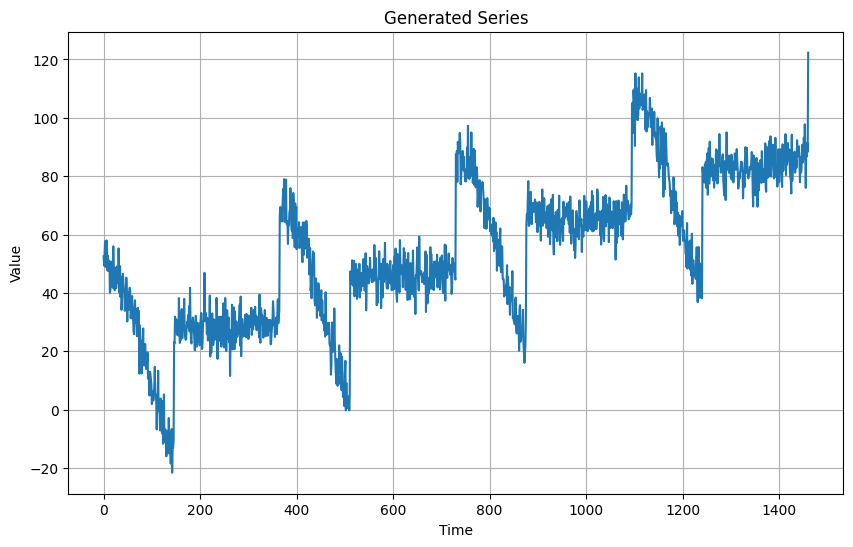

In [4]:
plot_series(time, series, title="Generated Series")

#### **1.2) Splitting the Dataset**

In [5]:
# Splitting the Dataset

# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

#### **1.3) Prepare Features and Labels, and Windowing preparation**

In [6]:
# Prepare features and labels
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


#### **1.4) Building the Model**

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routs its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`. 

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want to be the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [7]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


#### **1.5) Tuning the Learning Rate**

We will then tune the learning rate as before. 

We will define a learning rate schedule that changes this hyperparameter dynamically. 

We will also use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [8]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 91ms/step - loss: 28.7771 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 3s 92ms/step - loss: 25.6548 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 3s 92ms/step - loss: 22.0828 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 3s 83ms/step - loss: 18.3332 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 3s 81ms/step - loss: 14.8812 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 3s 83ms/step - loss: 12.1932 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 3s 80ms/step - loss: 10.9416 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 3s 80ms/step - loss: 10.6156 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 3s 81ms/step - loss: 10.5494 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 3s 82ms/step - loss: 10.5114 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 50.0)

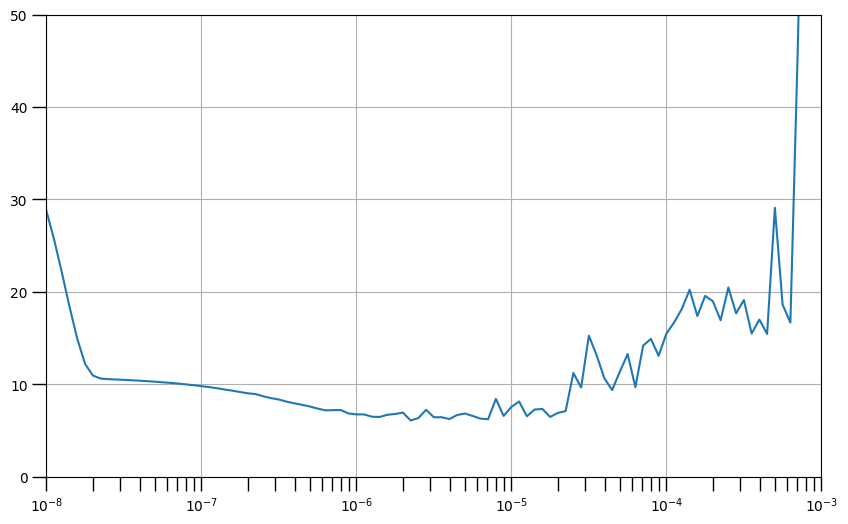

In [9]:
## Visualizing the results and pick an optimal learning rate
## ---------------------------------------------------------
lrs = 1e-8 * (10 ** (np.arange(100) / 20))      # Define the learning rate array
plt.figure(figsize=(10, 6))                     # Set the figure size
plt.grid(True)                                  # Set the grid
plt.semilogx(lrs, history.history["loss"])      # Plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both')   # Increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 50])                   # Set the plot boundaries

(1e-07, 0.0001, 0.0, 20.0)

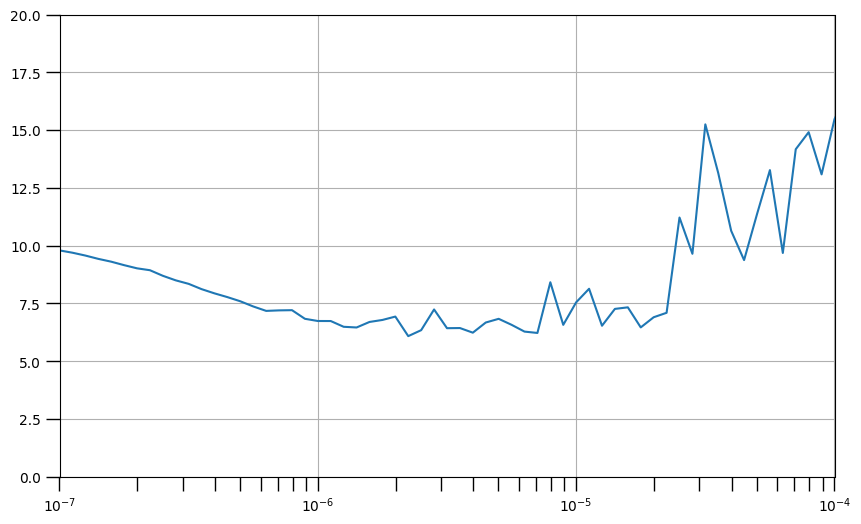

In [10]:
## We can change the boundaries of the graph if you want to zoom in. 
##  The cell below chooses a narrower range so you can see more clearly 
##  where the graph becomes unstable.
## --------------------------------------------------------------------
plt.figure(figsize=(10, 6))                                     # Set the figure size
plt.grid(True)                                                  # Set the grid
plt.semilogx(lrs, history.history["loss"])                      # Plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both')       # Increase the tickmarks size
plt.axis([1e-7, 1e-4, 0, 20])                                   # Set the plot boundaries

#### **1.6) Training the Model**

We can then declare the model again and train with the learning rate you picked. <br>
It is set to `1e-6`by default but feel free to change it.

In [11]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 4s 84ms/step - loss: 16.3427 - mae: 16.8369
Epoch 2/100
31/31 [==============================] - 3s 87ms/step - loss: 9.1188 - mae: 9.6001
Epoch 3/100
31/31 [==============================] - 3s 90ms/step - loss: 8.5933 - mae: 9.0817
Epoch 4/100
31/31 [==============================] - 3s 84ms/step - loss: 8.4769 - mae: 8.9632
Epoch 5/100
31/31 [==============================] - 3s 82ms/step - loss: 8.0839 - mae: 8.5661
Epoch 6/100
31/31 [==============================] - 3s 85ms/step - loss: 8.0659 - mae: 8.5516
Epoch 7/100
31/31 [==============================] - 3s 90ms/step - loss: 7.8736 - mae: 8.3627
Epoch 8/100
31/31 [==============================] - 3s 87ms/step - loss: 7.6888 - mae: 8.1725
Epoch 9/100
31/31 [==============================] - 3s 85ms/step - loss: 8.0034 - mae: 8.4919
Epoch 10/100
31/31 [==============================] - 3s 87ms/step - loss: 8.4038 - mae: 8.8863
Epoch 11/100
31/31 [===========================

#### **1.7) Predicting from the Model**

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. 

We can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

1/1 [==============================] - 0s 27ms/step


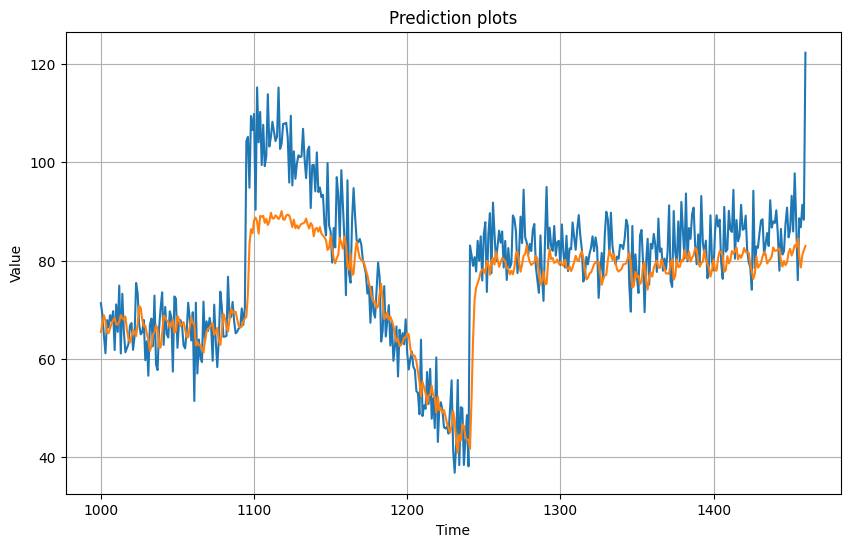

In [13]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), title="Prediction plots")

We can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, we can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. We will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.



*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

15/15 [==============================] - 0s 15ms/step
MSE:  76.406105
MAE:  6.423888


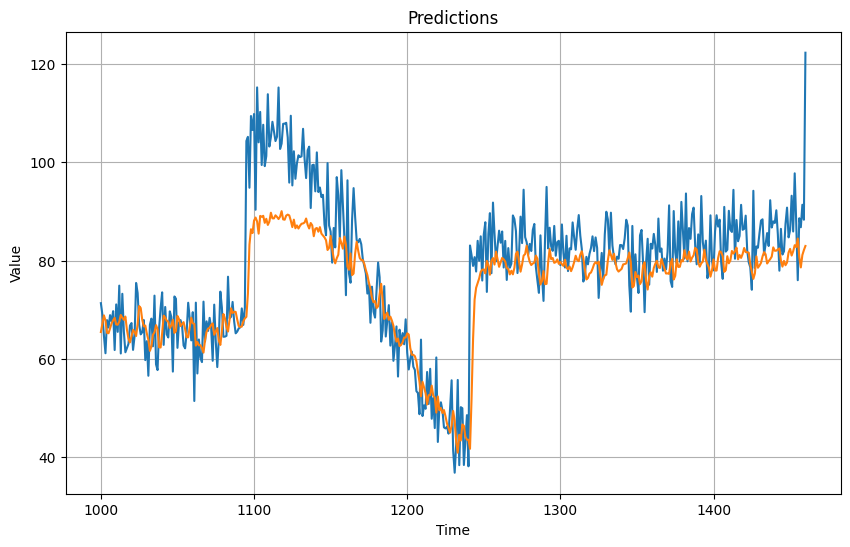

In [14]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

print("MSE: ",tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Plot the results
plot_series(time_valid, (x_valid, results), title = "Predictions")

## **2) Time Series with LSTM (Long Short Term Memory)**
------------------

#### **2.1) Generating the Series**

In [15]:
# Getting the time series
series, time = generate_synthetic_timeseries()

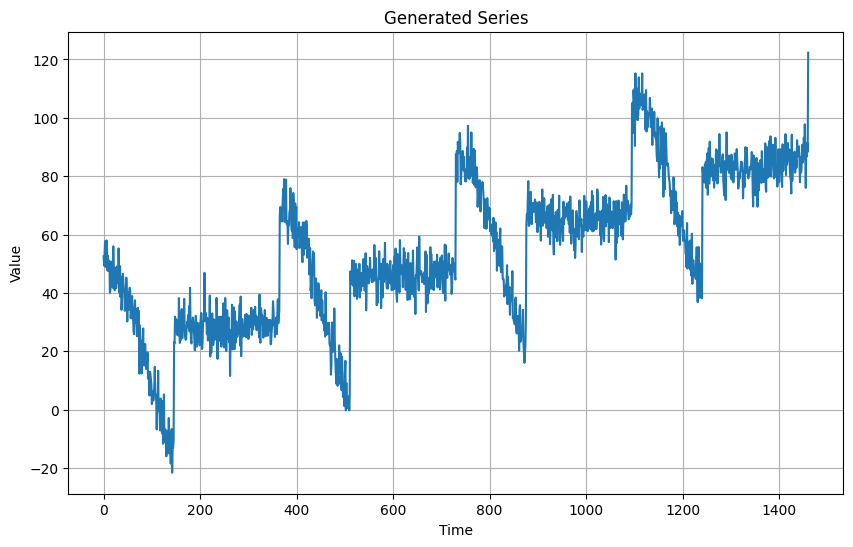

In [16]:
plot_series(time, series, title="Generated Series")

#### **2.2) Splitting the Dataset**

In [17]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

#### **1.3) Prepare Features and Labels, and Windowing preparation**

In [18]:
# Prepare features and labels
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


#### **2.4) Building the Model**

We will swap `SimpleRNN` for `LSTM` here. 

It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [19]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

#### **2.5) Tuning the Learning Rates**

In [20]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 7s 19ms/step - loss: 41.6385 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 35.9187 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 32.5833 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 30.1146 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 15ms/step - loss: 27.9025 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 15ms/step - loss: 25.7040 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 15ms/step - loss: 23.5205 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 15ms/step - loss: 21.4551 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 15ms/step - loss: 19.6157 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 14ms/step - loss: 18.0260 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 30.0)

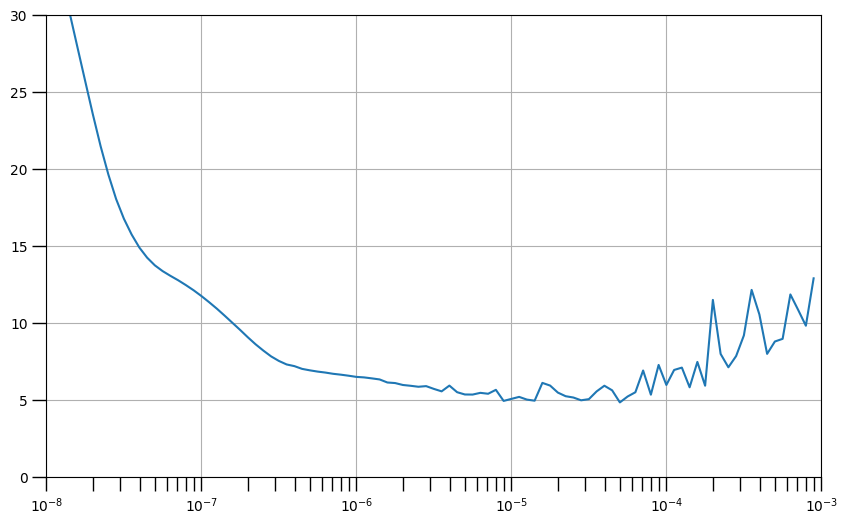

In [21]:
## Visualizing the results and pick an optimal learning rate
## ---------------------------------------------------------
lrs = 1e-8 * (10 ** (np.arange(100) / 20))      # Define the learning rate array
plt.figure(figsize=(10, 6))                     # Set the figure size
plt.grid(True)                                  # Set the grid
plt.semilogx(lrs, history.history["loss"])      # Plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both')   # Increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 30])                   # Set the plot boundaries

#### **2.6) Training the Model**

We can then proceed to train the model with your chosen learning rate. 

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*

In [22]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 25ms/step - loss: 21.0352 - mae: 21.5309
Epoch 2/100
31/31 [==============================] - 1s 14ms/step - loss: 11.3725 - mae: 11.8600
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 9.0231 - mae: 9.5093
Epoch 4/100
31/31 [==============================] - 1s 14ms/step - loss: 7.7106 - mae: 8.1934
Epoch 5/100
31/31 [==============================] - 1s 14ms/step - loss: 6.9407 - mae: 7.4211
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 6.5630 - mae: 7.0442
Epoch 7/100
31/31 [==============================] - 1s 14ms/step - loss: 6.3733 - mae: 6.8523
Epoch 8/100
31/31 [==============================] - 1s 15ms/step - loss: 6.1838 - mae: 6.6618
Epoch 9/100
31/31 [==============================] - 1s 14ms/step - loss: 6.0259 - mae: 6.5068
Epoch 10/100
31/31 [==============================] - 1s 15ms/step - loss: 5.9754 - mae: 6.4575
Epoch 11/100
31/31 [=========================

#### **2.7) Predicting from the Model**

15/15 [==============================] - 2s 15ms/step


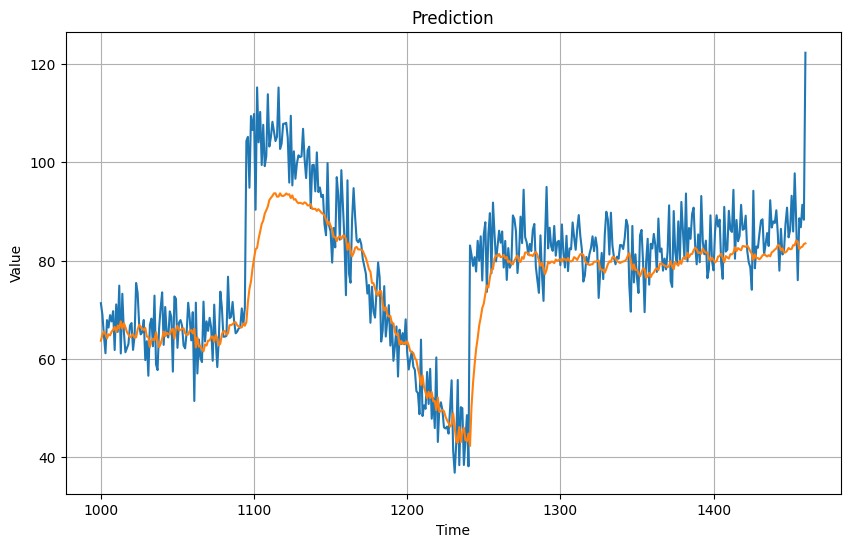

In [23]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), title='Prediction')

In [24]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

72.126045
6.042292
